# Celebrity Face Generation with GANs

In [1]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

DATA_DIR = '/home/mh731nk/_data/experiments_tmp/data/celeba_dataset/img_align_celeba'
# print(len(os.listdir(DATA_DIR+'/100k')))

In [3]:
print(os.listdir(DATA_DIR)[:10])

['img_align_celeba', '.DS_Store']


Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [4]:
image_size = 64
batch_size = 265
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

In [5]:
train_ds = ImageFolder(root=DATA_DIR, 
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size), # pick central square crop of it
                                            T.ToTensor(),
                                            T.Normalize(*stats)        # normalize => -1 to 1                               
                                        ]))



In [6]:

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.



In [7]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

Note that In Pytorch -> C x Hx W whereas Matplotlib reques H x W x C. So, permute(1, 2, 0) do this.

In [8]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

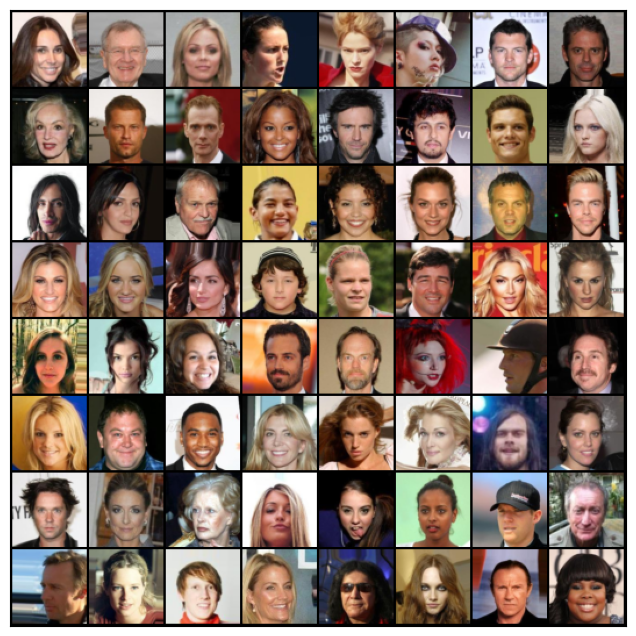

In [9]:
show_batch(train_dl)

## Using a GPU

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

# Build GAN

# Discriminator Network

In [13]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [14]:
discriminator = to_device(discriminator, device)

#### Lets print output shape after each layer of discrminator.

In [15]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Sigmoid output shape: 	 torch.Size([1, 1])


# Generator Network

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

#### Lets print output shape after each layer of generator.

In [18]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


#### Lets see fake_images generated by generator before training. Just for curiosity.

torch.Size([265, 3, 64, 64])


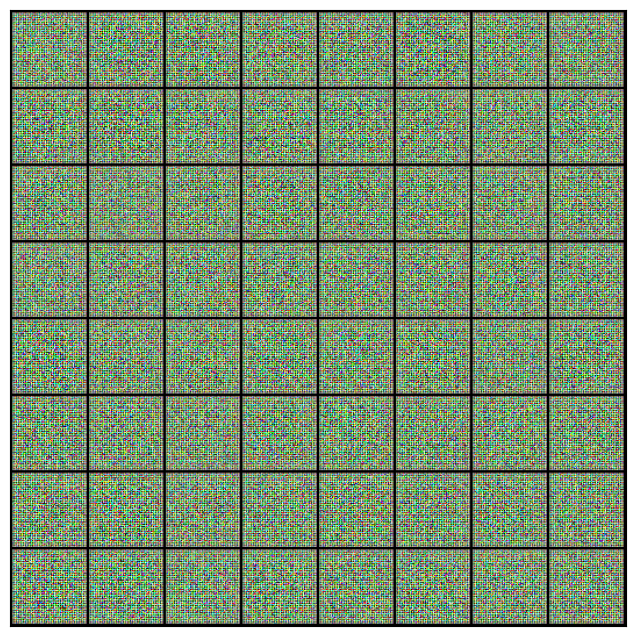

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


#### Remember in PyTorch, we have to move data, model in GPU for computation. So, `to_device` do that work.

In [20]:
generator = to_device(generator, device) # move generator to device

## Training Discriminator

In [21]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



Here are the steps involved in training the discriminator.

* We expect the discriminator to output 1 if the image was picked from the real Anime Faces dataset, and 0 if it was generated using the generator network.

* We first pass a batch of real images, and compute the loss, setting the target labels to 1.

* Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

* Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.



It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

## Generator Training

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [22]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator 
  loss.backward()
  opt_g.step()

  return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [23]:
from torchvision.utils import save_image


In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated=images-0000.png


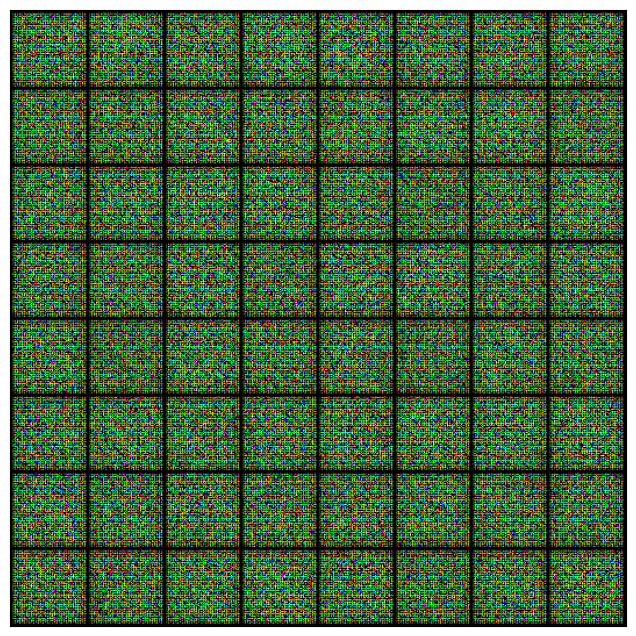

In [27]:
save_samples(0, fixed_latent)

## Training Loop

In [28]:
from tqdm import tqdm
import torch.nn.functional as F

In [29]:

def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for idx, epoch in enumerate(range(0,epochs)):
    print(f"epoch {idx} start")
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.



In [30]:
# Hyperparameters
lr = 0.00025
epochs = 60

In [31]:
# !pip install ipywidgets
device

device(type='cuda')

In [32]:
history = fit(epochs, lr)

epoch 0 start


100%|██████████| 765/765 [00:39<00:00, 19.31it/s]


Epoch [1/60], loss_g: 3.1127, loss_d: 0.4035, real_score: 0.7485, fake_score: 0.0725
Saving generated=images-0001.png
epoch 1 start


100%|██████████| 765/765 [00:40<00:00, 19.11it/s]


Epoch [2/60], loss_g: 4.3011, loss_d: 0.7027, real_score: 0.9248, fake_score: 0.4313
Saving generated=images-0002.png
epoch 2 start


100%|██████████| 765/765 [00:40<00:00, 18.96it/s]


Epoch [3/60], loss_g: 2.0541, loss_d: 0.7612, real_score: 0.5614, fake_score: 0.0715
Saving generated=images-0003.png
epoch 3 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [4/60], loss_g: 3.6248, loss_d: 0.6452, real_score: 0.9215, fake_score: 0.3992
Saving generated=images-0004.png
epoch 4 start


100%|██████████| 765/765 [00:40<00:00, 18.96it/s]


Epoch [5/60], loss_g: 3.6247, loss_d: 0.3535, real_score: 0.9474, fake_score: 0.2387
Saving generated=images-0005.png
epoch 5 start


100%|██████████| 765/765 [00:40<00:00, 18.95it/s]


Epoch [6/60], loss_g: 3.3767, loss_d: 0.1899, real_score: 0.8825, fake_score: 0.0543
Saving generated=images-0006.png
epoch 6 start


100%|██████████| 765/765 [00:40<00:00, 18.96it/s]


Epoch [7/60], loss_g: 4.4314, loss_d: 0.4717, real_score: 0.9492, fake_score: 0.3131
Saving generated=images-0007.png
epoch 7 start


100%|██████████| 765/765 [00:40<00:00, 18.94it/s]


Epoch [8/60], loss_g: 3.2585, loss_d: 0.7172, real_score: 0.5672, fake_score: 0.0437
Saving generated=images-0008.png
epoch 8 start


100%|██████████| 765/765 [00:40<00:00, 18.97it/s]


Epoch [9/60], loss_g: 5.9130, loss_d: 0.7328, real_score: 0.9579, fake_score: 0.4394
Saving generated=images-0009.png
epoch 9 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [10/60], loss_g: 3.3588, loss_d: 0.0486, real_score: 0.9766, fake_score: 0.0237
Saving generated=images-0010.png
epoch 10 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [11/60], loss_g: 3.9551, loss_d: 0.1746, real_score: 0.9060, fake_score: 0.0656
Saving generated=images-0011.png
epoch 11 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [12/60], loss_g: 2.9008, loss_d: 0.0892, real_score: 0.9729, fake_score: 0.0568
Saving generated=images-0012.png
epoch 12 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [13/60], loss_g: 2.2426, loss_d: 0.6255, real_score: 0.6000, fake_score: 0.0050
Saving generated=images-0013.png
epoch 13 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [14/60], loss_g: 4.0568, loss_d: 0.4177, real_score: 0.9518, fake_score: 0.2720
Saving generated=images-0014.png
epoch 14 start


100%|██████████| 765/765 [00:40<00:00, 18.98it/s]


Epoch [15/60], loss_g: 3.9696, loss_d: 0.1112, real_score: 0.9475, fake_score: 0.0515
Saving generated=images-0015.png
epoch 15 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [16/60], loss_g: 3.9493, loss_d: 0.1769, real_score: 0.9537, fake_score: 0.1118
Saving generated=images-0016.png
epoch 16 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [17/60], loss_g: 3.7522, loss_d: 0.0493, real_score: 0.9768, fake_score: 0.0238
Saving generated=images-0017.png
epoch 17 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [18/60], loss_g: 1.9985, loss_d: 0.3988, real_score: 0.7324, fake_score: 0.0195
Saving generated=images-0018.png
epoch 18 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [19/60], loss_g: 4.3277, loss_d: 0.1663, real_score: 0.8658, fake_score: 0.0059
Saving generated=images-0019.png
epoch 19 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [20/60], loss_g: 3.8615, loss_d: 0.0640, real_score: 0.9743, fake_score: 0.0357
Saving generated=images-0020.png
epoch 20 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [21/60], loss_g: 5.1379, loss_d: 0.0655, real_score: 0.9532, fake_score: 0.0141
Saving generated=images-0021.png
epoch 21 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [22/60], loss_g: 4.6351, loss_d: 0.1220, real_score: 0.9198, fake_score: 0.0291
Saving generated=images-0022.png
epoch 22 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [23/60], loss_g: 5.5285, loss_d: 0.1151, real_score: 0.9645, fake_score: 0.0679
Saving generated=images-0023.png
epoch 23 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [24/60], loss_g: 4.5470, loss_d: 0.0966, real_score: 0.9789, fake_score: 0.0672
Saving generated=images-0024.png
epoch 24 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [25/60], loss_g: 3.0455, loss_d: 0.1617, real_score: 0.8827, fake_score: 0.0242
Saving generated=images-0025.png
epoch 25 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [26/60], loss_g: 4.4928, loss_d: 0.2012, real_score: 0.8757, fake_score: 0.0390
Saving generated=images-0026.png
epoch 26 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [27/60], loss_g: 3.6504, loss_d: 0.2698, real_score: 0.9015, fake_score: 0.1265
Saving generated=images-0027.png
epoch 27 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [28/60], loss_g: 7.5161, loss_d: 1.8011, real_score: 0.9805, fake_score: 0.6812
Saving generated=images-0028.png
epoch 28 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [29/60], loss_g: 5.1797, loss_d: 0.0830, real_score: 0.9389, fake_score: 0.0149
Saving generated=images-0029.png
epoch 29 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [30/60], loss_g: 5.2056, loss_d: 0.0742, real_score: 0.9428, fake_score: 0.0116
Saving generated=images-0030.png
epoch 30 start


100%|██████████| 765/765 [00:40<00:00, 18.98it/s]


Epoch [31/60], loss_g: 4.5816, loss_d: 0.0733, real_score: 0.9470, fake_score: 0.0154
Saving generated=images-0031.png
epoch 31 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [32/60], loss_g: 3.5750, loss_d: 0.3207, real_score: 0.7934, fake_score: 0.0430
Saving generated=images-0032.png
epoch 32 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [33/60], loss_g: 5.0262, loss_d: 0.1111, real_score: 0.9366, fake_score: 0.0381
Saving generated=images-0033.png
epoch 33 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [34/60], loss_g: 5.0849, loss_d: 0.0305, real_score: 0.9916, fake_score: 0.0212
Saving generated=images-0034.png
epoch 34 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [35/60], loss_g: 4.4242, loss_d: 0.1588, real_score: 0.9744, fake_score: 0.1055
Saving generated=images-0035.png
epoch 35 start


100%|██████████| 765/765 [00:40<00:00, 19.03it/s]


Epoch [36/60], loss_g: 3.7524, loss_d: 0.1088, real_score: 0.9669, fake_score: 0.0669
Saving generated=images-0036.png
epoch 36 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [37/60], loss_g: 4.5725, loss_d: 0.0465, real_score: 0.9741, fake_score: 0.0187
Saving generated=images-0037.png
epoch 37 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [38/60], loss_g: 3.6328, loss_d: 0.1128, real_score: 0.9285, fake_score: 0.0310
Saving generated=images-0038.png
epoch 38 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [39/60], loss_g: 3.8261, loss_d: 0.0562, real_score: 0.9569, fake_score: 0.0094
Saving generated=images-0039.png
epoch 39 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [40/60], loss_g: 9.4546, loss_d: 2.0938, real_score: 0.9990, fake_score: 0.7844
Saving generated=images-0040.png
epoch 40 start


100%|██████████| 765/765 [00:40<00:00, 18.98it/s]


Epoch [41/60], loss_g: 5.6009, loss_d: 0.0989, real_score: 0.9775, fake_score: 0.0681
Saving generated=images-0041.png
epoch 41 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [42/60], loss_g: 5.0555, loss_d: 0.0373, real_score: 0.9803, fake_score: 0.0163
Saving generated=images-0042.png
epoch 42 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [43/60], loss_g: 4.2758, loss_d: 0.1346, real_score: 0.8855, fake_score: 0.0015
Saving generated=images-0043.png
epoch 43 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [44/60], loss_g: 6.1634, loss_d: 0.0704, real_score: 0.9820, fake_score: 0.0475
Saving generated=images-0044.png
epoch 44 start


100%|██████████| 765/765 [00:40<00:00, 18.97it/s]


Epoch [45/60], loss_g: 5.6085, loss_d: 0.0616, real_score: 0.9527, fake_score: 0.0104
Saving generated=images-0045.png
epoch 45 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [46/60], loss_g: 3.7777, loss_d: 0.1822, real_score: 0.9323, fake_score: 0.0881
Saving generated=images-0046.png
epoch 46 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [47/60], loss_g: 5.1209, loss_d: 0.0315, real_score: 0.9821, fake_score: 0.0119
Saving generated=images-0047.png
epoch 47 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [48/60], loss_g: 3.6571, loss_d: 0.1298, real_score: 0.9023, fake_score: 0.0141
Saving generated=images-0048.png
epoch 48 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [49/60], loss_g: 6.4293, loss_d: 0.0137, real_score: 0.9900, fake_score: 0.0034
Saving generated=images-0049.png
epoch 49 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [50/60], loss_g: 13.9356, loss_d: 2.3926, real_score: 0.9997, fake_score: 0.8012
Saving generated=images-0050.png
epoch 50 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]


Epoch [51/60], loss_g: 4.1748, loss_d: 0.0927, real_score: 0.9487, fake_score: 0.0329
Saving generated=images-0051.png
epoch 51 start


100%|██████████| 765/765 [00:40<00:00, 18.99it/s]


Epoch [52/60], loss_g: 2.1887, loss_d: 0.2504, real_score: 0.8228, fake_score: 0.0182
Saving generated=images-0052.png
epoch 52 start


100%|██████████| 765/765 [00:40<00:00, 19.03it/s]


Epoch [53/60], loss_g: 2.6811, loss_d: 0.7385, real_score: 0.5709, fake_score: 0.0088
Saving generated=images-0053.png
epoch 53 start


100%|██████████| 765/765 [00:40<00:00, 19.02it/s]


Epoch [54/60], loss_g: 5.2183, loss_d: 0.5452, real_score: 0.9530, fake_score: 0.3082
Saving generated=images-0054.png
epoch 54 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [55/60], loss_g: 5.7129, loss_d: 0.0266, real_score: 0.9931, fake_score: 0.0188
Saving generated=images-0055.png
epoch 55 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [56/60], loss_g: 3.8362, loss_d: 0.0533, real_score: 0.9670, fake_score: 0.0174
Saving generated=images-0056.png
epoch 56 start


100%|██████████| 765/765 [00:40<00:00, 19.03it/s]


Epoch [57/60], loss_g: 6.3326, loss_d: 0.0696, real_score: 0.9695, fake_score: 0.0335
Saving generated=images-0057.png
epoch 57 start


100%|██████████| 765/765 [00:40<00:00, 18.98it/s]


Epoch [58/60], loss_g: 5.2840, loss_d: 0.0551, real_score: 0.9748, fake_score: 0.0269
Saving generated=images-0058.png
epoch 58 start


100%|██████████| 765/765 [00:40<00:00, 19.01it/s]


Epoch [59/60], loss_g: 5.5965, loss_d: 0.1395, real_score: 0.9691, fake_score: 0.0863
Saving generated=images-0059.png
epoch 59 start


100%|██████████| 765/765 [00:40<00:00, 19.00it/s]

Epoch [60/60], loss_g: 4.6348, loss_d: 0.0527, real_score: 0.9797, fake_score: 0.0290
Saving generated=images-0060.png


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.



In [ ]:
from IPython.display import Image


In [ ]:
Image('./generated/generated=images-0001.png')


In [ ]:
Image('./generated/generated=images-0005.png')


In [ ]:
Image('./generated/generated=images-0010.png')


In [ ]:
Image('./generated/generated=images-0020.png')


In [ ]:
Image('./generated/generated=images-0025.png')


In [ ]:
Image('./generated/generated=images-0030.png')

In [ ]:
Image('./generated/generated=images-0035.png')

In [ ]:
Image('./generated/generated=images-0040.png')

In [ ]:
Image('./generated/generated=images-0045.png')

In [ ]:
Image('./generated/generated=images-0050.png')

In [ ]:
Image('./generated/generated=images-0055.png')

In [ ]:
Image('./generated/generated=images-0060.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.



In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

print("Starting converting images to video.")
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

print(files)

fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fname,fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

Here's what it looks like:



We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');